# 2D Ferromagnetic Ising on a PBC Square Lattice

$$H = -J\sum_{\langle ij\rangle} \sigma_i\sigma_j$$

By inspection, we see that the ground states of this system correspond to all spins pointing in the same direction. 
Our goal is to find one of the ground state(s) automatically through Monte Carlo sampling.

The probability distribution of the Ising model at temperature $T$ is given by the Gibbs distribution:

$$p(\sigma; T) = \frac{1}{Z(T)}\exp\left(-\frac{H(\sigma)}{T}\right)$$

where $Z(T)$ is the normalization constant (also known as the *partition function*).


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from common.ising_animator import IsingAnimator
from common.abstract_ising import AbstractIsing

%matplotlib inline

Below you'll find code for the Ising model of interest. Strictly speaking, for the purposes of performing the Monte Carlo simulation we can simply compute the required energy differences using two calls to the `energy` function. However, we can often save significant computation time by writing a specialised function for the energy difference that avoids unnecessary calculations. Simply put, calculating the energy of a configuration of spins requires you to iterate over all spins in the lattice, but the energy change associated with a single-spin-flip can be computed just from values of the adjacent spins.

In [3]:
class Ising2DPBC(AbstractIsing):
    def __init__(self, Nx, Ny, J=1.):
        self.J, self.Nx, self.Ny = J, Nx, Ny
        self.num_spins = self.Nx * self.Ny
        
        # initialize system at infinite temperature
        # i.e. spins are completely random and uncorrelated
        self.spins = 2*(np.random.rand(self.Nx, self.Ny) < 0.5) - 1
    
    def energy(self):
        """Returns the energy of the current spin configuration"""
        horizontal = np.sum(np.roll(self.spins, 1, axis=0) * self.spins)
        vertical = np.sum(np.roll(self.spins, 1, axis=1) * self.spins)

        total = -self.J * (horizontal + vertical)

        return total

    def energy_diff(self, i, j):
        """Returns the energy difference resulting from flipping the site at coordinates (i,j)"""
        # sum the nearest neighbour sites
        nn_sum = (
            self.spins[i-1, j] 
            + self.spins[(i+1) % self.Nx, j] 
            + self.spins[i, j-1] 
            + self.spins[i, (j+1) % self.Ny]
        )

        return 2 * self.J * self.spins[i, j] * nn_sum
    
    def rand_site(self):
        """Selects a site in the lattice at random"""
        i = np.random.randint(self.Nx)
        j = np.random.randint(self.Ny)
        return i, j

We generate a starting configuration for our Monte Carlo simulation:

In [4]:
ising = Ising2DPBC(10, 10, J=1)
ising.spins

array([[ 1, -1,  1, -1, -1,  1, -1,  1,  1,  1],
       [ 1,  1,  1,  1,  1, -1, -1, -1, -1,  1],
       [ 1, -1, -1,  1,  1,  1,  1, -1,  1,  1],
       [ 1,  1,  1, -1,  1,  1,  1, -1, -1, -1],
       [ 1, -1,  1,  1, -1, -1, -1,  1, -1,  1],
       [ 1,  1, -1, -1,  1, -1, -1,  1, -1, -1],
       [-1, -1,  1,  1,  1,  1, -1, -1,  1, -1],
       [ 1,  1, -1, -1,  1,  1,  1, -1,  1,  1],
       [-1,  1, -1,  1, -1, -1,  1, -1, -1,  1],
       [-1,  1, -1, -1, -1, -1, -1,  1,  1,  1]])

In [5]:
# perform 1000 MC steps at T=1
for t in range(1000):
    # take a look at the abstract_ising.py file to see how mc_step works
    E = ising.mc_step(T=1.0)
    
    if t % 50 == 0:
        print(E)

-72
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200


In [6]:
ising.spins

array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

If all the spins are the same, then we've already found the ground state for our system. It's fairly easy in this case as we're dealing with a simple model and a small system size.

Next we'll demonstrate a temperature annealing algorithm in order to more systematically target the ground state.

The annealing schedule we'll use is a simple exponential annealer:

$$T(t) = T_i \left(\frac{T_f}{T_i}\right)^{t/N}$$

where $t = 0, \dots, N$, $T(0) = T_i$, and $T(N) = T_f$

In [7]:
N = 500
t = np.arange(N+1)
T_i = 100
T_f = 0.01

T = T_i * ((T_f/T_i) ** (t/N))

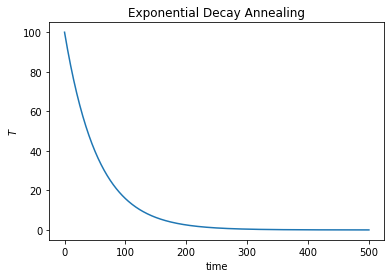

In [8]:
plt.plot(t, T)
plt.title("Exponential Decay Annealing")
plt.ylabel("$T$")
plt.xlabel("time");

We'll perform the annealing through a special class that allows us to visualize the current state of the Ising spins as the temperature is lowered. It performs a standard Metropolis-Hastings Monte Carlo just as above, but each call to the `mc_step` function is performed at the temperature given by the provided annealing schedule and the current configuration of the spins is shown. Look at the `ising_animator.py` if you're curious to see how it works.

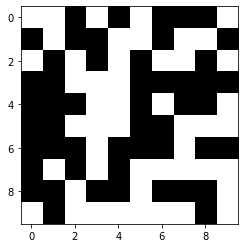

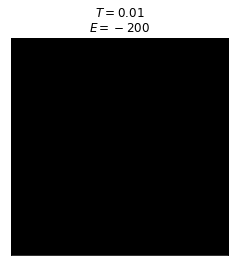

In [9]:
# reinitialize so we're back at a T=infinity state
ising = Ising2DPBC(10, 10, J=1)
plt.imshow(ising.spins, cmap="gray")  # show the starting configuration

# NOTE: sometimes the animation gets stuck displaying a single image
# The most reliable way to fix this is by restarting the notebook.
# Initializing the Ising Model in the same cell as the one where you
# run the animation also seems to work.
animator = IsingAnimator(ising)
animator.run_animation(T)

If the ground state was found, we should see the plot completely fill up with a single color. Since the 2D Ising Model is fairly simple, this happens quite often. In some cases however, we may see the formation of distinct domains, in which there is a straight line separating two domains of opposite spin. If this happens to you, simply run the simulation again until the plot is uniform. An example of domain seperation is shown in the video below:

In [10]:
from IPython.display import Video

Video("media/domain_wall.mp4")

States with domain separation correspond to local minima of the energy. Ideally, our annealer should be able to help us escape or avoid these local minima and find one of the global minima (ground states). Note that we tend to get stuck in these local minima more often if our annealing occurs too quickly (i.e. non-adiabatically). To see this, change $N$ above to a smaller value (say 50) and observe how often you get stuck with seperated domains.